### Open File

In [11]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [12]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [13]:
df = df.dropna(subset=['Dist_Center'])

### Filter by City

In [14]:
df = df[df.City == 'Milan']

### Create Predicted Category for final models (2 categories)

In [15]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [16]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [17]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df)

Good    0.829145
Bad     0.170855
Name: Category, dtype: float64

### Balance Nationalities and / or Categories

In [18]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [19]:
df_balanced_1 = balance_df(df, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*2))
df_balanced_2.shape

(9994, 78)

In [20]:
df_balanced_2.Nationality_Recode.value_counts()

Western Europe         1797
UK & Ireland           1795
Middle east            1611
Eastern Europe         1501
North America          1034
Asia & Pacific          902
Oceania                 807
South/Latin America     195
China                   158
Sub-Saharian Africa     132
Arab States              62
Name: Nationality_Recode, dtype: int64

### Prepare Data to run Models

In [21]:
if len(df_balanced_2) > 20000:
    df_model = df_balanced_2.sample(n=20000, random_state=1)
else:
    df_model = df_balanced_2.copy()

df_model.shape

(9994, 78)

In [22]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [23]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [24]:
df_model['Review_Month'] = df_model['Review_Month'].astype(str)
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [25]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)

In [27]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((4997, 71), (4997,), (4997, 71), (4997,))

## MODELS

### Evaluate Model

In [28]:
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score, make_scorer

In [29]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [30]:
def evaluate_random(model, params, iterations, X_train, X_test, y_train, y_test, verbose = 1):
    clf = RandomizedSearchCV(estimator = model, param_distributions = params, n_iter = iterations, 
                             n_jobs = -1, cv = 5, random_state = 27, verbose = verbose)
    clf.fit(X_train, y_train)
    print(clf.best_params_, clf.best_score_)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [31]:
def evaluate_grid(model, params, X_train, X_test, y_train, y_test, verbose = 1):
    f1 = make_scorer(f1_score, pos_label = "Bad")
    clf = GridSearchCV(estimator = model, param_grid = params, n_jobs = -1, cv = 5, verbose = verbose)    
    clf.fit(X_train, y_train)
    print(clf.best_params_, clf.best_score_)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [32]:
def print_result(clf, X_train, X_test, y_train, y_test):
    print('Accuracy Test :', f'{accuracy_score(clf.predict(X_test), y_test):.4f}', 
          '| F1 Test :', f'{f1_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}')
    print('Accuracy Train:', f'{accuracy_score(clf.predict(X_train), y_train):.4f}', 
          '| F1 Train:', f'{f1_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}')

### KNN

In [33]:
pred_knn = evaluate_model(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test)

Accuracy Test : 0.5996 | F1 Test : 0.5920
Accuracy Train: 0.7476 | F1 Train: 0.7446


### Gradient Boosted Trees

In [34]:
iterations = 100
params = {'learning_rate':  [0.001, 0.0025, 0.005 , 0.01, 0.025, 0.05, 0.1], 
          'n_estimators': range(100, 200),
          'max_depth': [2, 3, 4, 5],
          'min_samples_split': np.linspace(0.1, 1.0, 100, endpoint=True),
          'min_samples_leaf': np.linspace(0.01, 0.5, 100, endpoint=True), 
          'subsample': [1], 
          'max_features': ['sqrt']}

pred_gbt = evaluate_random(GradientBoostingClassifier(), params, iterations, X_train, X_test, y_train, y_test, verbose = 0)

{'subsample': 1, 'n_estimators': 107, 'min_samples_split': 0.4181818181818182, 'min_samples_leaf': 0.014949494949494949, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.025} 0.6636036036036035
Accuracy Test : 0.6468 | F1 Test : 0.6569
Accuracy Train: 0.6702 | F1 Train: 0.6859


In [35]:
# pred_gbt = evaluate_model(GradientBoostingClassifier(n_estimators = 165, 
#                                                      min_samples_split = 0.6272727272727272, 
#                                                      min_samples_leaf = 0.11888888888888888, 
#                                                      max_depth = 2, learning_rate = 0.001),
#                           X_train, X_test, y_train, y_test)

### Random Forest

In [36]:
iterations = 100
params = {'bootstrap': [True, False],
          'max_depth': range(1, 10),
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': range(1, 10),
          'min_samples_split': range(1, 10),
          'n_estimators': range(100, 200)}

pred_rf = evaluate_random(RandomForestClassifier(random_state = 1), params, iterations, 
                          X_train, X_test, y_train, y_test, verbose = 0)

{'n_estimators': 144, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': False} 0.6535947947947948
Accuracy Test : 0.6406 | F1 Test : 0.6529
Accuracy Train: 0.6924 | F1 Train: 0.7064


In [37]:
# pred_rf = evaluate_model(RandomForestClassifier(n_estimators = 153, min_samples_split = 5,  min_samples_leaf = 7,
#                                                 max_features = 'auto', max_depth = 2, bootstrap = False, random_state=1), 
#                          X_train, X_test, y_train, y_test)

### XGBoosting

In [38]:
iterations = 250
params = {"learning_rate"    : [0.0001, 0.005, 0.001, 0.005, 0.01, 0.05, 0.10, 0.25, 0.50],
          "max_depth"        : [2, 3, 4, 5, 6, 7, 8, 9, 10],
          "min_child_weight" : [1, 3, 5, 10, 25, 50, 100, 250],
          "gamma"            : [0.01, 0.05, 0.1, 0.15, 0.25, 0.50, 0.75, 0.95],
          "colsample_bytree" : [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2],
          "n_estimators"     : [2, 3, 5, 7, 10, 15, 25, 50, 100]}

pred_xgb = evaluate_random(xgb.XGBClassifier(), params, iterations, X_train, X_test, y_train, y_test, verbose = 0)

{'n_estimators': 7, 'min_child_weight': 50, 'max_depth': 3, 'learning_rate': 0.5, 'gamma': 0.75, 'colsample_bytree': 0.7} 0.665803003003003
Accuracy Test : 0.6448 | F1 Test : 0.6516
Accuracy Train: 0.6746 | F1 Train: 0.6840


In [39]:
# pred_xgb = evaluate_model(xgb.XGBClassifier(n_estimators = 7, min_child_weight = 5, max_depth = 3, learning_rate = 0.005,
#                                             gamma = 0.05, colsample_bytree = 1, random_state = 1), 
#                     X_train, X_test, y_train, y_test)

### Logistic Regresion

In [40]:
params = {"C": [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1],
          "tol": [0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]}

pred_log = evaluate_grid(LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 1), 
                         params, X_train, X_test, y_train, y_test, verbose = 0)

{'C': 0.005, 'tol': 1e-05} 0.6579965965965966
Accuracy Test : 0.6498 | F1 Test : 0.6463
Accuracy Train: 0.6666 | F1 Train: 0.6669


In [41]:
# pred_log = evaluate_model(LogisticRegression(C = 0.1, tol = 0.00001, solver='lbfgs', max_iter=1000, random_state=1), 
#                           X_train, X_test, y_train, y_test)

### Decision Trees

In [42]:
iterations = 1000
params = {"max_depth": range(1, 10),
          "max_features": range(1, 20),
          "min_samples_leaf": range(1, 20),
          "criterion": ["gini", "entropy"]}

pred_tree = evaluate_random(DecisionTreeClassifier(random_state = 1), params, iterations, 
                            X_train, X_test, y_train, y_test, verbose = 0)

{'min_samples_leaf': 15, 'max_features': 15, 'max_depth': 4, 'criterion': 'gini'} 0.6459861861861861
Accuracy Test : 0.6296 | F1 Test : 0.6299
Accuracy Train: 0.6484 | F1 Train: 0.6560


In [43]:
# pred_tree = evaluate_model(DecisionTreeClassifier(min_samples_leaf = 4, max_features = 19, max_depth = 3, 
#                                                   criterion = 'entropy', random_state = 1), 
#                      X_train, X_test, y_train, y_test)

### SVM

In [44]:
params = {"degree": [2, 3, 4],
          "kernel": ['poly'], 
          "C":      [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2.5, 5]}

pred_svm = evaluate_grid(SVC(random_state = 1), params, X_train, X_test, y_train, y_test, verbose = 0)

{'C': 0.1, 'degree': 2, 'kernel': 'poly'} 0.6395865865865866
Accuracy Test : 0.6338 | F1 Test : 0.6333
Accuracy Train: 0.6548 | F1 Train: 0.6589


In [45]:
# pred_svm = evaluate_model(SVC(kernel = 'poly', degree = 2, C = 0.005, random_state = 1), X_train, X_test, y_train, y_test)

### Naive Bayes

In [46]:
params = {"alpha": [0.1, 0.25, 0.5, 1, 2.5, 5, 10], 
          "fit_prior": [True, False]}

pred_nb = evaluate_grid(BernoulliNB(), params, X_train, X_test, y_train, y_test, verbose = 0)

{'alpha': 10, 'fit_prior': True} 0.6489937937937938
Accuracy Test : 0.6358 | F1 Test : 0.6244
Accuracy Train: 0.6508 | F1 Train: 0.6470


In [47]:
# pred_nb = evaluate_model(BernoulliNB(alpha=0.25, fit_prior=True), X_train, X_test, y_train, y_test)

## STACKING

Predictions using Random Forest adding the predicions of other models to the original dataset.
I had to split the test set in 2 to create the new train/test set, otherwise i fall into overfitting because my original training set is biased vs the test set

First I append the predictions of the model to the dataset

In [48]:
X_2 = X_test.copy()
y_2 = y_test.copy()

In [49]:
X_2['logistic'] = pred_log
X_2['gbt'] = pred_gbt
X_2['knn'] = pred_knn
X_2['svm'] = pred_svm
X_2['tree'] = pred_tree
X_2['xgb'] = pred_xgb
X_2['nb'] = pred_nb
X_2['rf'] = pred_rf

In [50]:
X_2.iloc[:,-8:].head(2)

,logistic,gbt,knn,svm,tree,xgb,nb,rf
20233,Bad,Bad,Good,Bad,Bad,Bad,Bad,Bad
9944,Good,Good,Good,Good,Good,Good,Good,Good


In [51]:
X_2.iloc[:,-8:] = X_2.iloc[:,-8:].apply(lambda x: [1 if i=='Good' else 0 for i in x])

In [52]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=100)

### Gradient Boosting Trees

In [53]:
iterations = 100
params = {'learning_rate':  [0.001, 0.0025, 0.005 , 0.01, 0.025, 0.05, 0.1], 
          'n_estimators': range(100, 200),
          'max_depth': [2, 3, 4, 5],
          'min_samples_split': np.linspace(0.1, 1.0, 100, endpoint=True),
          'min_samples_leaf': np.linspace(0.01, 0.5, 100, endpoint=True), 
          'subsample': [1], 
          'max_features': ['sqrt']}
          
pred_gbt_stck = evaluate_random(GradientBoostingClassifier(random_state = 1), params, iterations, 
                                X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'subsample': 1, 'n_estimators': 183, 'min_samples_split': 0.4636363636363636, 'min_samples_leaf': 0.11393939393939392, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.005} 0.6487396745932416
Accuracy Test : 0.6430 | F1 Test : 0.6331
Accuracy Train: 0.6492 | F1 Train: 0.6535


### XGB

In [54]:
iterations = 250
params = {"learning_rate"    : [0.0001, 0.005, 0.001, 0.005, 0.01, 0.05, 0.10, 0.25, 0.50],
          "max_depth"        : [2, 3, 4, 5, 6, 7, 8, 9, 10],
          "min_child_weight" : [1, 3, 5, 10, 25, 50, 100, 250],
          "gamma"            : [0.01, 0.05, 0.1, 0.15, 0.25, 0.50, 0.75, 0.95],
          "colsample_bytree" : [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2],
          "n_estimators"     : [2, 3, 5, 7, 10, 15, 25, 50, 100]}

pred_xgb_stck = evaluate_random(xgb.XGBClassifier(random_state = 1), params, iterations, 
                                X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'n_estimators': 3, 'min_child_weight': 250, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.05, 'colsample_bytree': 1.0} 0.6529918648310387
Accuracy Test : 0.6370 | F1 Test : 0.6191
Accuracy Train: 0.6530 | F1 Train: 0.6528


### SVM

In [55]:
params = {"degree": [2, 3, 4],
          "kernel": ['poly'], 
          "C":      [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2.5]}

pred_svm_stck = evaluate_grid(SVC(random_state = 1), params, X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'C': 1, 'degree': 2, 'kernel': 'poly'} 0.6459874843554443
Accuracy Test : 0.6400 | F1 Test : 0.6341
Accuracy Train: 0.6753 | F1 Train: 0.6812


### Logistic Regression

In [56]:
params = {"C": [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1],
          "tol": [0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]}

pred_log_stck = evaluate_grid(LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 1), 
                                params, X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'C': 0.01, 'tol': 1e-05} 0.6532428035043805
Accuracy Test : 0.6420 | F1 Test : 0.6271
Accuracy Train: 0.6630 | F1 Train: 0.6640


### Decision Trees

In [57]:
iterations = 200
params = {"max_depth": range(1, 10),
          "max_features": range(1, 20),
          "min_samples_leaf": range(1, 20),
          "criterion": ["gini", "entropy"]}

pred_tree_stck = evaluate_random(DecisionTreeClassifier(random_state = 1), params, iterations, 
                                 X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 5, 'criterion': 'gini'} 0.6462403003754694
Accuracy Test : 0.6310 | F1 Test : 0.6128
Accuracy Train: 0.6695 | F1 Train: 0.6662


## BACKWARD ELIMINATION

In [58]:
import random
from random import sample

In [59]:
def try_seed(seed, verbose=True):
    score = check_model('', X_train_2, X_test_2, y_train_2, y_test_2)[1]
    varout = []
    varin = list(X_test_2.columns)

    for n in range(len(varin)):
        max_score = score
        max_feature = []
        random.seed(seed)
        
        for i in sample(varin, len(varin)):
            var_test = varin.copy()
            var_test.remove(i)
            X_train_vartest = X_train_2[var_test]
            X_test_vartest = X_test_2[var_test]
            check = check_model(i, X_train_vartest, X_test_vartest, y_train_2, y_test_2)
            if check[1] > max_score:
                max_feature = check[0]
                max_score = check[1] 
                varin.remove(max_feature)   
                varout.append(max_feature)
                if verbose:
                    print('{0:0=2d}'.format(n), 'Original Score:', f'{score:.4f}', '| New score:', f'{max_score:.4f}', 
                          end='\r', flush=True)
                break

        if max_score > score:
            score = max_score
        else:
            print('Seed:',seed, '<-', f'{score:.4f}','                                                                       ')
            return(varin, score)
            break

### Logistic Regression

In [60]:
def check_model(variable, X_train, X_test, y_train, y_test):
    clf = LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 1, tol = 0.00001, C = 0.01)     
    clf.fit(X_train, y_train)
    score = accuracy_score(clf.predict(X_train), y_train)
    return(variable, score)

In [61]:
max_score = 0
var_selec = []
for seed in range(10):
    varin, score = try_seed(seed, verbose=True)
    if score > max_score:
        max_score = score
        var_selec = varin

Seed: 0 <- 0.6683                                                                        
Seed: 1 <- 0.6678                                                                        Original Score: 0.6647 | New score: 0.6652
Seed: 2 <- 0.6670                                                                        
Seed: 3 <- 0.6662                                                                        
Seed: 4 <- 0.6685                                                                        
Seed: 5 <- 0.6678                                                                        
Seed: 6 <- 0.6693                                                                        
Seed: 7 <- 0.6693                                                                        
Seed: 8 <- 0.6668                                                                        
Seed: 9 <- 0.6698                                                                        


In [64]:
X_train_varin = X_train_2
X_test_varin = X_test_2

clf = LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 1, tol = 0.001, C = 0.05)
clf.fit(X_train_varin, y_train_2)
print("F1-Score: ", f1_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("Accuracy: ", accuracy_score(clf.predict(X_test_varin), y_test_2))
print("Recall:   ", recall_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("Precision:", precision_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))

F1-Score:  0.6264308012486992
Accuracy:  0.641
Recall:    0.6487068965517241
Precision: 0.6056338028169014


In [65]:
pd.crosstab(clf.predict(X_test_varin), y_test_2)

Category,Bad,Good
row_0,,
Bad,301,163
Good,196,340


## CONFIDENCE INTERVAL

In [66]:
predicciones = []

for i in range(10000):
    sample = np.random.randint(0, len(X_test_varin), size=len(X_test_varin))
    X_sample = X_test_varin.iloc[sample]
    y_sample = y_test_2.iloc[sample]
    print(i, end='\r', flush=True)
    predicciones.append(accuracy_score(clf.predict(X_sample), y_sample))

(array([1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 7.000e+00,
        2.500e+01, 4.400e+01, 7.300e+01, 1.450e+02, 2.280e+02, 3.620e+02,
        6.640e+02, 7.020e+02, 8.450e+02, 9.790e+02, 1.060e+03, 1.040e+03,
        1.158e+03, 7.910e+02, 6.180e+02, 4.620e+02, 3.060e+02, 2.210e+02,
        1.510e+02, 6.100e+01, 3.100e+01, 1.400e+01, 6.000e+00, 3.000e+00]),
 array([0.571     , 0.57516667, 0.57933333, 0.5835    , 0.58766667,
        0.59183333, 0.596     , 0.60016667, 0.60433333, 0.6085    ,
        0.61266667, 0.61683333, 0.621     , 0.62516667, 0.62933333,
        0.6335    , 0.63766667, 0.64183333, 0.646     , 0.65016667,
        0.65433333, 0.6585    , 0.66266667, 0.66683333, 0.671     ,
        0.67516667, 0.67933333, 0.6835    , 0.68766667, 0.69183333,
        0.696     ]),
 <a list of 30 Patch objects>)

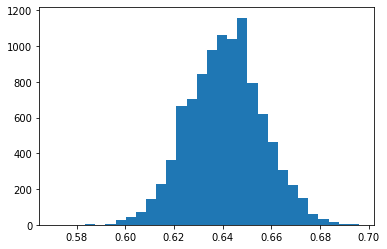

In [67]:
plt.hist(predicciones, bins=30)

In [68]:
np.percentile(predicciones, 2.5), np.percentile(predicciones, 50), np.percentile(predicciones, 97.5)

(0.611, 0.641, 0.671)